# 1 Author




**Student Name:**   Shalini Jain 

**Student ID:**     210973020




# 2 Problem Formulation



In this notebook, we will be building a machine learning pipeline which will take a subset of MLEnd Hums and Whistles dataset containing only Potter and StarWars songs and build different models to classify the two songs. The same model can further be trained in future to determine gender, genre, etc.






# 3 Machine Learning pipeline

A machine learning pipeline is a way to codify and automate the workflow to produce a machine learning model. Machine learning pipelines consist of multiple sequential steps that do everything from data extraction and preprocessing to model training and deployment.

1. **Data Preprocessing:** In this step raw data is generated and merged into one single framework. In our case we will be collecting MLEnd Hums and Whistle dataset  from the QMUL repository and that will be stored in the private google drive. Potter and StarWars audio files are used to extract and clean the information about the data. 

2. **Data Cleaning:** 
Data cleaning refers to identifying and correcting errors in the dataset that may negatively impact a predictive model. Eliminating all the duplicates,incorrect file format and other errors.

3. **Feature Engineering:** Feature Engineering is the process of extracting useful features from the raw audio samples to perform an efficient model training. The input for this stage will be a time series data loaded using librosa library at a particular frequency. The output will be 2 dimensional array having four features for each audio file.

4. **Model tuning and training:** This stage involves analyzing different models and comparing the results. The models can further be tuned for better performance by adding different hyperparameters and selecting the best parameters for the model. This can be achieved by using various cross-validation methods like GridSearchCV, RandomizedSearchCV, etc.

5. **Evaluate the model's performance:** Evaluate the accuracy of our model on the validation data which is 30% of the training dataset.This involves analysing the performance of the final model using several metrics. The input for this stage has the test data and the trained model to obtain metrices such as confusion matrix and the classification report having recall, precision, f1 score and support values.

# 4 Transformation Stage

This is the most crucial stage in constructing machine learning models and it often decides the performance of your model. This stage is further divided into two sections:


*   **Data pre-processing**

      MLEnd Hums and Whistle Data consists of raw audio files in a wav format. This stage involves reading all the files and extracting relevenat information like filename, Particpant Id, song name, interpretation type.
*   **Feature Extraction**

      The audio files are in the wav format and it consists of thousands of dimensions. We can use the `librosa` library to read the audio files which loads them as samples recorded at a frequency `fs`. We can see the output samples for an audio file as below

      This visualization is called the time-domain representation of a given signal. This shows us the loudness (amplitude) of sound wave changing with time.

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa
import zipfile
from matplotlib import cm

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


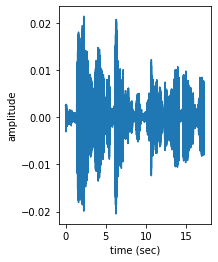

In [ ]:
#In this example we have taken random audio file from our dataset for plotting purpose
#The waveforms can be plotted in different forms like mono and stereo. Here we have plotted waveform in mono format
x, fs = librosa.load(file_list[0][3],sr=None)
t = np.arange(len(x))/fs
plt.subplot(1, 2, 1)
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(file_list[0][3]))


Due to high dimension of sample features, we need to extract a few relevant features from the samples for training the model. To extract relevant features we will be using **STFT**.

For the binary classication of the audio files in this notebook, we have used different combination of these audio features to build different machine learning models:




---








* **MFCC** - MFCC or Mel Frequency Ceptral Coefficients are a set of features obtained by converting the conventional frequency to the Mel scale which describes the overall shape of a spectral envelope. We can consider first 20 to 40 coefficients in our feature extraction.

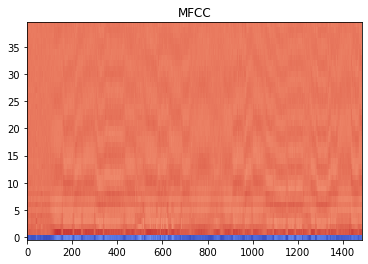

In [ ]:
fig, ax = plt.subplots()
mfcc_data = librosa.feature.mfcc(x,n_mfcc=40)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
ax.set_title('MFCC')
plt.show()

* **Mel Spectrogram** - A spectrogram is obtained by stacking a set of FFT(Fast Fourier Transforms) on each other. A Mel Spectrogram is a spectrogram converted to the Mel scale. This is useful for modelling human hearing perception.

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

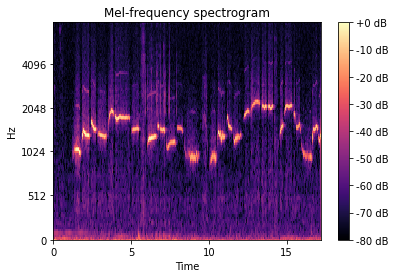

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
S = librosa.feature.melspectrogram(y=x, sr=fs, n_mels=128,
                                    fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=fs,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

* **Spectral Bandwidth** - Spectral bandwidth is the portion of a signal which contains most of the energy of the signal. 


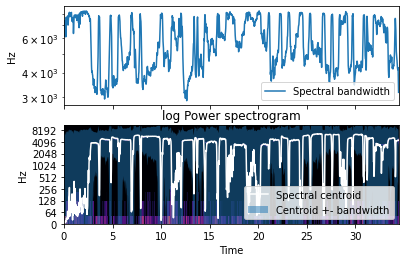

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, sharex=True)
spec_bw = librosa.feature.spectral_bandwidth(y=x, sr=fs)
times = librosa.times_like(spec_bw)
centroid = librosa.feature.spectral_centroid(S=S)
ax[0].semilogy(times, spec_bw[0], label='Spectral bandwidth')
ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')
ax[1].fill_between(times, centroid[0] - spec_bw[0], centroid[0] + spec_bw[0],
                alpha=0.5, label='Centroid +- bandwidth')
ax[1].plot(times, centroid[0], label='Spectral centroid', color='w')
ax[1].legend(loc='lower right')

* **Spectral centroid** - Spectral centroid is a measure of the mass of the center of a spectrum.

[Text(0.5, 1.0, 'log Power spectrogram')]

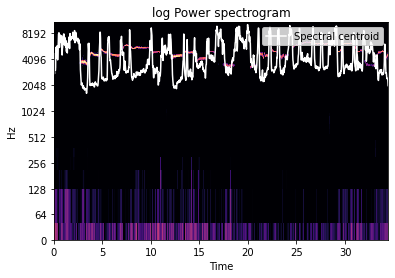

In [ ]:
centroid = librosa.feature.spectral_centroid(y=x, sr=fs)
times = librosa.times_like(centroid)
fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(times, centroid.T, label='Spectral centroid', color='w')
ax.legend(loc='upper right')
ax.set(title='log Power spectrogram')

* **Zero Crossing rate** - The zero crossing rate indicates the number of times that a signal crosses the horizontal axis.



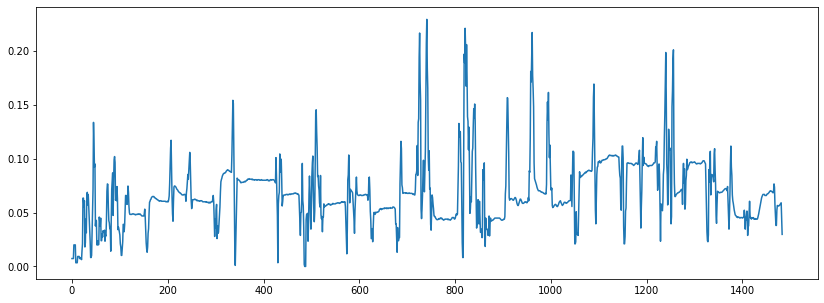

In [ ]:
zcrs = librosa.feature.zero_crossing_rate(x)
plt.figure(figsize=(14, 5))
plt.plot(zcrs[0])

# 5 Modelling

We will analyze some of the classic Machine learning classification models like **k-Nearest-Neighbout clasifier(kNN)**, **LogisticRegression classifier**, **Decision Trees**, **Random Forest Classifier** etc.

We will further analyze the top classification model in detail. We will also  tune our models using hyperparameter tuning for better results and accuracy. This is important to our scenario as our model has a large number of features and tuning the parameters for the model can be costly.

We can apply the **GridSearchCV**, **RandomSearchCV** library to run the model for several combinations of parameters to identify the best ones. We can analyze our results on both 3 and 5 fold cross validation for the classifier.

Also we need to scale data before training our model as there are multiple features and can have multiple value ranges and thus our model can give more weight to the faeture having higher range. For this purpose we will be using Sklearn library's **StandardScaler**.

To build and run different models sklearn library's machine learning pipeline is used which will automate the process and calculate accuracy of each model in the pipeline to measure performance.

# 6. Methodology
We will split the data set into train set(70%) and test set(30%). We will then run the trained model against the test data to access the performance.

Below are the steps which are used in evaluating the performance of the model:



*   Train the selected model on a training dataset.
*   Evaluating the model on a validation datasetset 
*   Hyperparameter tuning
*   Training the model again with best parameters and test the accuracy.


**Evaluation Measures:**

**Confusion Matrix:**
A confusion matrix is a summary of prediction results on a classification problem. In our case since we have two classes(StarWars, Potter)it will give us 2 X 2 matrix with True Positive values, True Negative values, False Positive and False Negative values for the classification.


**Precision**  Precision refers to the number of true positives divided by the total number of positive predictions 

**Recall** It is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.

# 7 Dataset

We have taken a subset of MLEnd Hums and Whistle data set for building the model in this notebook. The sample data consists of hums and whistles of the songs `Potter` and `StarWars`. 

We have two folders: `Potter` and `StarWars` where the folder of the name indicates the class of the audio file they contain. We can load the files separately and assign the class labels based on the folder name.

The data is loaded from a google drive folder which is mounted in google colab.

In [ ]:
path = '/content/drive/MyDrive/ML_Labs/Data/Songs/'

labels = ['Potter', 'StarWars']
file_list = []
for label in labels:
  sample_path = path + label + '/*.wav'
  print("The number of files for " + label + " is "  + str(len(glob.glob(sample_path))))
  file_list.append(glob.glob(sample_path))

The number of files for Potter is 411
The number of files for StarWars is 413


# 8. Results

We will first extract the relevant features from the sampled audio data. We will use below functions to calculate different features 

In [ ]:
def getMFCC(waveform, sampling_rate):
  # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
  # with 40 coefficients
  mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sampling_rate, n_mfcc=40))
  return mfc_coefficients

In [ ]:
def getMelSpectogram(waveform, sampling_rate):
  spec = np.mean(librosa.feature.melspectrogram(y=waveform,sr=sampling_rate))
  return spec

In [ ]:
def getTempo(waveform, sampling_rate):
  tempo= librosa.beat.tempo(y=waveform,sr=sampling_rate)
  return tempo

In [ ]:
def getSpectralBandwidth(waveform, sampling_rate):
  spec_bw= np.mean(librosa.feature.spectral_bandwidth(y=waveform,sr=sampling_rate))
  return spec_bw

In [ ]:
def getSpectralCentroid(waveform, sample_rate):
  sc_coefficients = np.mean(librosa.feature.spectral_centroid(y=waveform, sr=sample_rate).T, axis=0)
  return sc_coefficients

In [ ]:
def getZeroCrossingRate(waveform):
  #compute zcr, Zero crossing rate which determines the rate at which signal crosses zero while moving from +ve to -ve or vice versa
  zcr_coefficients = np.mean(librosa.feature.zero_crossing_rate(y=waveform).T, axis = 0)
  return zcr_coefficients

In [ ]:
def getZeroCrossingRate(waveform):
  #compute zcr, Zero crossing rate which determines the rate at which signal crosses zero while moving from +ve to -ve or vice versa
  zcr_coefficients = np.mean(librosa.feature.zero_crossing_rate(y=waveform).T, axis = 0)
  return zcr_coefficients

We will use features like MFCC, mel spectogram, spectral bandwidth and tempo to evaluate performance of our models.

In [ ]:
labels = ['Potter', 'StarWars']
def get_features(files):
  X,y = [],[]
  for i in range(0,len(labels)):
    for j in tqdm(range(0,len(files[i]))):
      yi = labels[i]
      x, sr = librosa.load(files[i][j],sr=None) 

      MFCCs = getMFCC(x,sr).flatten()
      mel_spec = getMelSpectogram(x,sr)
      tempo = getTempo(x,sr)
      spec_bw = getSpectralBandwidth(x, sr)

      xi = [ mel_spec, tempo, np.mean(spec_bw), MFCCs]
      X.append(xi)
      y.append(yi)
  return np.array(X), np.array(y)

In [ ]:
X, y = get_features(file_list)

100%|██████████| 413/413 [05:00<00:00,  1.37it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
df = pd.DataFrame(X, columns = ['mel_spec','tempo','spec_bw','MFCCs']).set_index(y)
df

mel_spec                 tempo      spec_bw         MFCCs
Potter    0.007846          [172.265625]   5142.03351  [-17.621126]
Potter    0.000608  [120.18531976744185]  5266.609683   [-21.50125]
Potter    0.004962   [139.6748310810811]  4765.788845  [-21.670408]
Potter    0.002279  [120.18531976744185]  5767.036432   [-26.03194]
Potter    3.040391          [123.046875]  1981.262522  [-11.944511]
...            ...                   ...          ...           ...
StarWars  1.469496       [107.666015625]  1726.818536  [-22.566328]
StarWars  0.136132  [101.33272058823529]  2891.146104   [-22.31084]
StarWars  0.276267   [99.38401442307692]  3148.085497  [-20.766644]
StarWars  0.186325  [126.04801829268293]   4053.91706  [-30.624329]
StarWars  0.166462  [117.45383522727273]  4168.479754   [-28.91114]

[824 rows x 4 columns]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((576, 4), (248, 4), (576,), (248,))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

classification_models = [
                         KNeighborsClassifier(n_neighbors=3),
                         LogisticRegression(),
                         DecisionTreeClassifier(),
                         RandomForestClassifier(n_estimators=500),
                         ]

model_scores = []
for model in classification_models:
  # Pipeline object is created to perform model training and evaluate the performance of each model.
  model_pipeline = Pipeline([('scaler', StandardScaler()), ('model_training', model)])
  model_pipeline.fit(X_train, y_train)

  model_name = type(model).__name__
  
  model_scores.append((model_name,(f'{100*model_pipeline.score(X_test, y_test):.2f}%')))

# Create the dataframe for score of each model
df_model_scores = pd.DataFrame(model_scores,columns=['Classification Model','Accuracy Score'])
df_model_scores.sort_values(by='Accuracy Score',axis=0,ascending=False)



Classification Model Accuracy Score
3  RandomForestClassifier         75.00%
1      LogisticRegression         72.58%
2  DecisionTreeClassifier         71.37%
0    KNeighborsClassifier         66.94%

## 8.2 Model Training and Evaluation: 

We will further evaluate RandomForest by adding more features and then compute accuracy of the models.



*   **RandomForestClassifier**

    It's an ensemble learning method of classification which opeartes by constructing several decision trees. This model gives accurate even without much hyperparameter tuning. This is important in this dataset as our model has a large number of features and tuning the parameters for the model can be costly.



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


pipeline_rfc = Pipeline([('scaler', StandardScaler()), ('rfc', RandomForestClassifier())])
pipeline_rfc.fit(X_train, y_train)

rfc_y_train_pred = pipeline_rfc.predict(X_train)
rfc_y_val_pred = pipeline_rfc.predict(X_test)

print("Training Accuracy for RandomForestClassifier pipeline: {}".format(pipeline_rfc.score(X_train, y_train)))
print("Validation Accuracy for RandomForestClassifier pipeline: {}".format(pipeline_rfc.score(X_test, y_test)))

Training Accuracy for RandomForestClassifier pipeline: 1.0
Validation Accuracy for RandomForestClassifier pipeline: 0.7419354838709677


From the above results we can see that the model is overfitting and we need to tune the model for better validation accuracy. We will use **GridSearchCV** for tuning parameters of our model. GridSearchCV is a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = { 
    'n_estimators': [50,100,200,300,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,6],
    'criterion' :['gini', 'entropy']
}

model = RandomForestClassifier(random_state=42)
CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 6],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200, 300, 500]})

**We can display the best hyperparameters and use those parameters to evaluate performance of our model**

In [ ]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'auto',
 'n_estimators': 100}

In [ ]:
rfc_tuned = RandomForestClassifier(random_state=42, criterion= 'gini',
 max_depth= 3,
 max_features='auto',
 n_estimators= 100)

rfc_tuned.fit(X_train, y_train)
y_train_pred = rfc_tuned.predict(X_train)
y_test_pred = rfc_tuned.predict(X_test)

print("Validation accuracy",accuracy_score(y_test, y_test_pred))
print("Training accuracy",accuracy_score(y_train, y_train_pred))

Validation accuracy 0.7379032258064516
Training accuracy 0.7795138888888888


After hyperparameter tuning there is a significant increase in the performance of our model and the model is no longer overfitting.

Let's dig deeper into performance measures of our model


Precision                                   : 0.6884057971014492
Recall                                      : 0.811965811965812
F1-Score                                    : 0.7450980392156863

Precision Recall F1-Score Support Per Class : 
 (array([0.6884058, 0.8      ]), array([0.81196581, 0.67175573]), array([0.74509804, 0.73029046]), array([117, 131]))

Classification Report                       : 
              precision    recall  f1-score   support

      Potter       0.69      0.81      0.75       117
    StarWars       0.80      0.67      0.73       131

    accuracy                           0.74       248
   macro avg       0.74      0.74      0.74       248
weighted avg       0.75      0.74      0.74       248



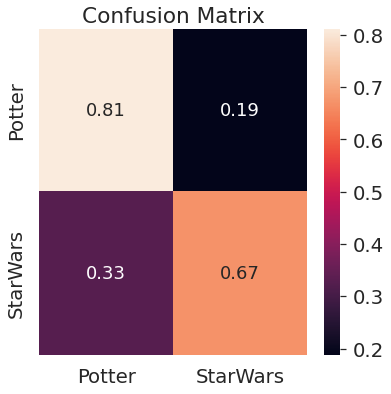

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sn
conf_matrix = confusion_matrix(y_test, y_test_pred,normalize='true')

song_list =['Potter', 'StarWars']
song_name = [song for song in song_list]

confmatrix_df = pd.DataFrame(conf_matrix, index=song_name, columns=song_name)

with plt.style.context(('ggplot', 'seaborn')):
    fig = plt.figure(figsize=(6,6), num=1)
    sn.set(font_scale=1.8) # emotion label and title size
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

print('Precision                                   : ' + str(precision_score(y_test, y_test_pred, average="binary", pos_label="Potter")))
print('Recall                                      : ' + str(recall_score(y_test, y_test_pred, pos_label="Potter")))
print('F1-Score                                    : ' + str(f1_score(y_test, y_test_pred, pos_label="Potter")))
print('\nPrecision Recall F1-Score Support Per Class : \n',precision_recall_fscore_support(y_test, y_test_pred))
print('\nClassification Report                       : ')
print(classification_report(y_test, y_test_pred))

From the above the confusion matrix, we can see that 81% of `Potter` songs and 67% `StarWars` has been classified correctly. This shows that model is more precise in predicting the `Potter` songs than the `StarWars` songs.

## 8.2.1 Further Analysis

The performance of the model can further be improved by improving feature extraction stage and adding more relevant features to our model like spectral centroid and spectral bandwidth. 

We will again extract features with 20 MFCC coefficients and construct a dataframe for visualization purpose.

In [ ]:
labels = ['Potter', 'StarWars']
def get_features(files):
  X,y = [],[]
  for i in range(0,len(labels)):
    for j in tqdm(range(0,len(files[i]))):
      yi = labels[i]
      x, sr = librosa.load(files[i][j],sr=None) 

      zcr_coefficients = np.mean(getZeroCrossingRate(x))
      MFCCs = np.mean(librosa.feature.mfcc(x, n_mfcc=20).flatten())
      mel_spec = librosa.feature.melspectrogram(y=x,sr=sr)
      tempo = librosa.beat.tempo(y=x,sr=sr)
      spec_bw = librosa.feature.spectral_bandwidth(y=x, sr=sr)
      spec_cent = getSpectralCentroid(x,sr)

      xi = [ np.mean(mel_spec), tempo, np.mean(spec_bw),spec_cent,zcr_coefficients,MFCCs]
      X.append(xi)
      y.append(yi)
  return np.array(X), np.array(y)

In [ ]:
X_new, y_new = get_features(file_list)

100%|██████████| 413/413 [05:40<00:00,  1.21it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
df_new = pd.DataFrame(X_new, columns = ['mel_spec','tempo','spec_bw','spec_cent','zcr_coefficients','MFCCs']).set_index(y_new)
df_new

mel_spec                 tempo      spec_bw             spec_cent  \
Potter    0.007846          [172.265625]   5142.03351   [2965.937032230426]   
Potter    0.000608  [120.18531976744185]  5266.609683  [4031.2188846635167]   
Potter    0.004962   [139.6748310810811]  4765.788845   [2475.002768438265]   
Potter    0.002279  [120.18531976744185]  5767.036432   [4436.822075744661]   
Potter    3.040391          [123.046875]  1981.262522   [951.8203990906383]   
...            ...                   ...          ...                   ...   
StarWars  1.469496       [107.666015625]  1726.818536  [1374.2759258217134]   
StarWars  0.136132  [101.33272058823529]  2891.146104   [1692.387209653584]   
StarWars  0.276267   [99.38401442307692]  3148.085497  [1994.2790809451606]   
StarWars  0.186325  [126.04801829268293]   4053.91706  [3511.5644784370347]   
StarWars  0.166462  [117.45383522727273]  4168.479754   [3465.540068855841]   

         zcr_coefficients      MFCCs  
Potter           0.036607 -16.540197  
Potter           0.090304 -21.371918  
Potter           0.019544  -18.62031  
Potter           0.068537 -27.273115  
Potter           0.013935  -5.438882  
...                   ...        ...  
StarWars         0.034003 -15.427261  
StarWars         0.027695  -14.94852  
StarWars         0.032396 -14.034429  
StarWars         0.100042 -28.528599  
StarWars         0.086931 -26.676346  

[824 rows x 6 columns]

In [ ]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new,y_new,test_size=0.3)
X_train_new.shape, X_test_new.shape, y_train_new.shape, y_test_new.shape

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = { 
    'n_estimators': [50,100,200,300,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,6],
    'criterion' :['gini', 'entropy']
}

model = RandomForestClassifier(random_state=42)
CV_rfc_new = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
CV_rfc_new.fit(X_train_new, y_train_new)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 6],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200, 300, 500]})

In [ ]:
CV_rfc_new.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'auto',
 'n_estimators': 300}

In [ ]:
rfc_new_tuned = RandomForestClassifier(random_state=42, criterion= 'gini',
 max_depth= 3,
 max_features='auto',
 n_estimators= 100)

rfc_new_tuned.fit(X_train_new, y_train_new)
y_train_new__pred = rfc_new_tuned.predict(X_train_new)
y_test_new_pred = rfc_new_tuned.predict(X_test_new)

print("Validation accuracy",accuracy_score(y_test_new, y_test_new_pred))
print("Training accuracy",accuracy_score(y_train_new, y_train_new__pred))

Validation accuracy 0.7943548387096774
Training accuracy 0.765625


We can also determine contribution of each feature in the model and this can be further used in larger dataset to improve performance

In [ ]:
features = df_new.reset_index(drop=True)
# List of features for later use
feature_list = list(features.columns)
importances = list(rfc_new_tuned.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: tempo                Importance: 0.65
Variable: mel_spec             Importance: 0.11
Variable: spec_cent            Importance: 0.07
Variable: zcr_coefficients     Importance: 0.07
Variable: MFCCs                Importance: 0.07
Variable: spec_bw              Importance: 0.04


[None, None, None, None, None, None]

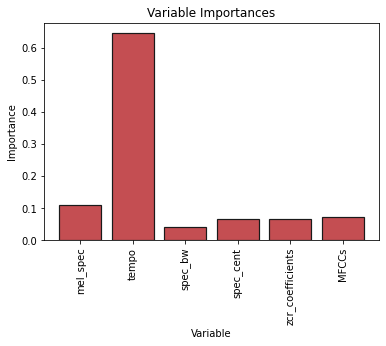

In [ ]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Precision                                   : 0.7647058823529411
Recall                                      : 0.8863636363636364
F1-Score                                    : 0.8210526315789474

Precision Recall F1-Score Support Per Class : 
 (array([0.76470588, 0.84210526]), array([0.88636364, 0.68965517]), array([0.82105263, 0.75829384]), array([132, 116]))

Classification Report                       : 
              precision    recall  f1-score   support

      Potter       0.69      0.81      0.75       117
    StarWars       0.80      0.67      0.73       131

    accuracy                           0.74       248
   macro avg       0.74      0.74      0.74       248
weighted avg       0.75      0.74      0.74       248



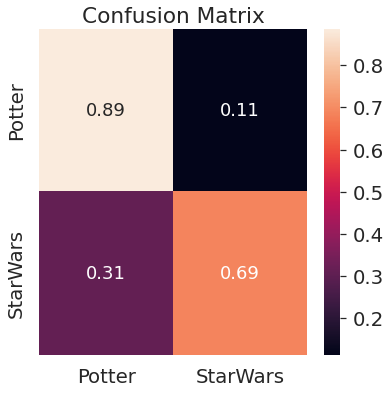

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sn
conf_new_matrix = confusion_matrix(y_test_new, y_test_new_pred,normalize='true')

song_list =['Potter', 'StarWars']
song_name = [song for song in song_list]

confmatrix_df_new = pd.DataFrame(conf_new_matrix, index=song_name, columns=song_name)

with plt.style.context(('ggplot', 'seaborn')):
    fig = plt.figure(figsize=(6,6), num=1)
    sn.set(font_scale=1.8) # emotion label and title size
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    sn.heatmap(confmatrix_df_new, annot=True, annot_kws={"size": 18}) #annot_kws is value font

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

print('Precision                                   : ' + str(precision_score(y_test_new, y_test_new_pred, average="binary", pos_label="Potter")))
print('Recall                                      : ' + str(recall_score(y_test_new, y_test_new_pred, pos_label="Potter")))
print('F1-Score                                    : ' + str(f1_score(y_test_new, y_test_new_pred, pos_label="Potter")))
print('\nPrecision Recall F1-Score Support Per Class : \n',precision_recall_fscore_support(y_test_new, y_test_new_pred))
print('\nClassification Report                       : ')
print(classification_report(y_test, y_test_pred))

Fron the above confusion matrix, we could see that post adding two relevant features will help the model to predict the song more effectively. 89% of the **Potter** songs and 69% of **StarWars** were classified correctly whereas, before adding two extra features the model predicted 81% and 67% for Potter and StarWars respectively.

# 9. Conclusions

Using the Random Forest Classifier model, we have obtained an training accuracy of ~77% and a testing accuracy of ~73%. The model has a slight overfitting considering the training acccuarcy is higher than the testing accuracy. 

We have also learned about the importance of Feature extraction and scaling and how it is the most important part of the machine learning piepline and thus needs more in-depth research.

After further anlayzing features we have added two more features to our model and analyzed the performance of our model which is slightly underfitting as it performs well on validation dataset (79%) and slighlty less on training dataset(76%)
